<a href="https://colab.research.google.com/github/11TRNP/Autoimmune-Nonautoimmune-Classification/blob/main/MobileNetV2%2086%25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from keras.layers import Rescaling
from keras.layers import Resizing

# System libraries
from pathlib import Path
import os.path
import random

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns

sns.set_style('darkgrid')

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [29]:
from google.colab import drive
import os

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
base_dir = '/content/drive/My Drive/DATASET/source'
output_dir = '/content/drive/My Drive/DATASET/output'
train_dir = '/content/drive/My Drive/DATASET/output/train'
val_dir = '/content/drive/My Drive/DATASET/output/val'
test_dir = '/content/drive/My Drive/DATASET/output/test'
augmented_dir = '/content/drive/My Drive/DATASET/output/augmented/'

print(os.listdir(augmented_dir))
print(" ")
print(os.listdir(output_dir))

['Autoimun_Dermatomyositis', 'Autoimun_Vitiligo', 'Autoimun_Psoriasis', 'Autoimun_Lichen_Planus', 'Nonautoimun_Tinea', 'Nonautoimun_Eczema', 'Nonautoimun_Herpes', 'Nonautoimun_Keratosis_Seborrheic', 'labels_augmented.csv']
 
['test', 'val', 'manipulation', 'train', 'augmented', 'mask']


In [ ]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [ ]:
image_dir = Path(augmented_dir)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))  + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.gif'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

<ipython-input-13-371b102a4acd>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')


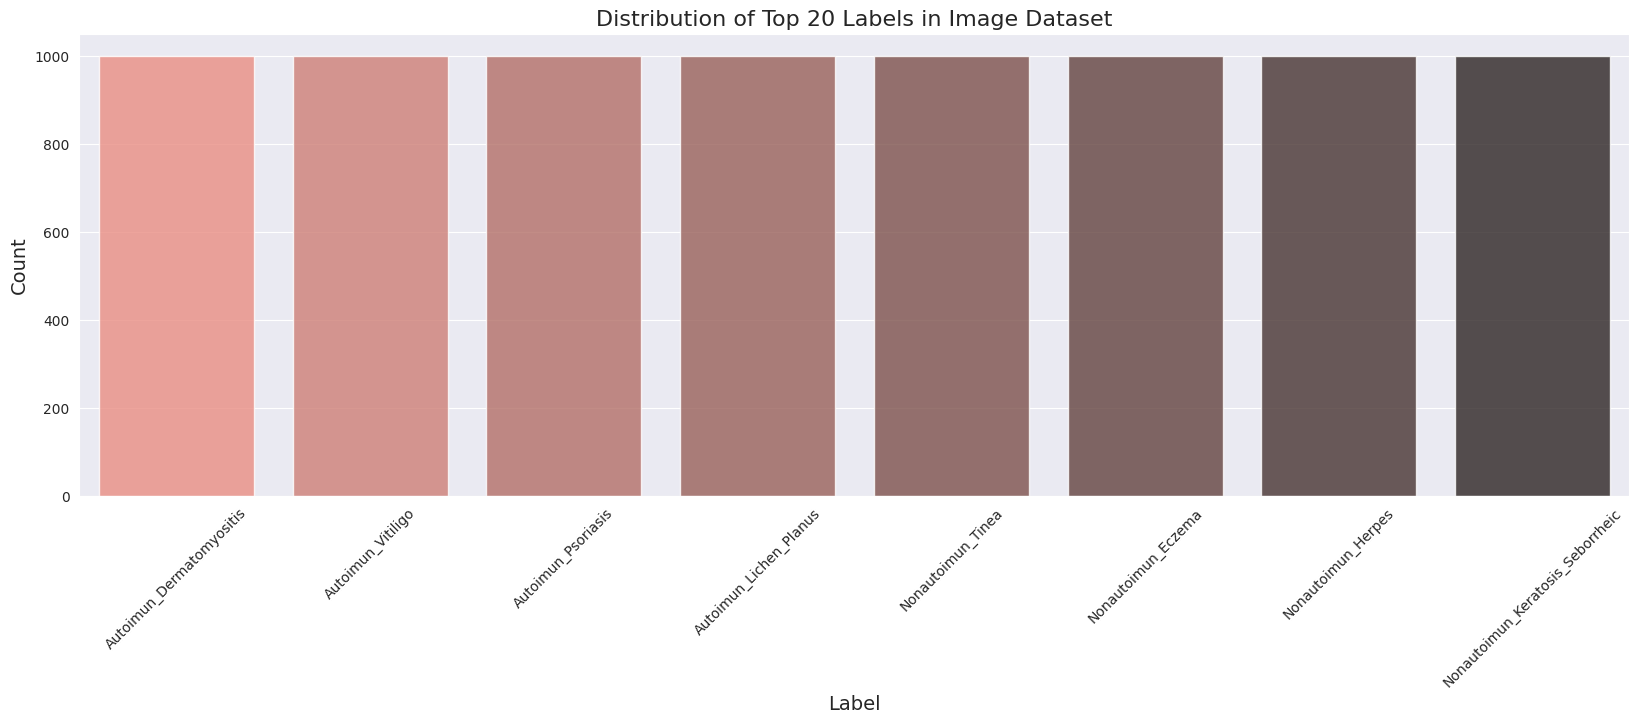

In [ ]:
# Get the top 20 labels
label_counts = image_df['Label'].value_counts()[:20]

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')
plt.title('Distribution of Top 20 Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [ ]:
image_df

Filepath  \
0     /content/drive/My Drive/DATASET/output/augment...   
1     /content/drive/My Drive/DATASET/output/augment...   
2     /content/drive/My Drive/DATASET/output/augment...   
3     /content/drive/My Drive/DATASET/output/augment...   
4     /content/drive/My Drive/DATASET/output/augment...   
...                                                 ...   
7995  /content/drive/My Drive/DATASET/output/augment...   
7996  /content/drive/My Drive/DATASET/output/augment...   
7997  /content/drive/My Drive/DATASET/output/augment...   
7998  /content/drive/My Drive/DATASET/output/augment...   
7999  /content/drive/My Drive/DATASET/output/augment...   

                                 Label  
0             Autoimun_Dermatomyositis  
1             Autoimun_Dermatomyositis  
2             Autoimun_Dermatomyositis  
3             Autoimun_Dermatomyositis  
4             Autoimun_Dermatomyositis  
...                                ...  
7995  Nonautoimun_Keratosis_Seborrheic  
7996  Nonautoimun_Keratosis_Seborrheic  
7997  Nonautoimun_Keratosis_Seborrheic  
7998  Nonautoimun_Keratosis_Seborrheic  
7999  Nonautoimun_Keratosis_Seborrheic  

[8000 rows x 2 columns]

In [ ]:
import pandas as pd
import os
from google.colab import sheets

# Daftar nama penyakit
diseases = ['Autoimun_Dermatomyositis', 'Autoimun_Vitiligo', 'Autoimun_Psoriasis', 'Autoimun_Lichen_Planus',
            'Nonautoimun_Tinea', 'Nonautoimun_Eczema', 'Nonautoimun_Herpes', 'Nonautoimun_Keratosis_Seborrheic']

# Assuming 'Filepath' column contains the image paths
# Ambil path base directory dari DataFrame image_df
base_dir = os.path.dirname(image_df['Filepath'][0])  # Changed 'image' to 'Filepath'

# Buat list kosong untuk menyimpan data
data = []

# Iterasi melalui setiap baris di image_df
for index, row in image_df.iterrows():
    # Use 'Filepath' column instead of 'image'
    image_path = row['Filepath']

    # Ekstrak nama penyakit dari path gambar
    disease_name = os.path.basename(os.path.dirname(image_path))

    # Buat dictionary untuk setiap baris data
    row_data = {'image': image_path} # You might want to change this key to 'Filepath' for consistency

    # Inisialisasi semua label penyakit menjadi 0
    for d in diseases:
        row_data[d.lower()] = 0

    # Set label penyakit yang sesuai menjadi 1
    if disease_name in diseases:
        row_data[disease_name.lower()] = 1

    # Tambahkan baris data ke list
    data.append(row_data)

# Buat DataFrame dari list data
label_df = pd.DataFrame(data)

print(label_df)

                                                  image  \
0     /content/drive/My Drive/DATASET/output/augment...   
1     /content/drive/My Drive/DATASET/output/augment...   
2     /content/drive/My Drive/DATASET/output/augment...   
3     /content/drive/My Drive/DATASET/output/augment...   
4     /content/drive/My Drive/DATASET/output/augment...   
...                                                 ...   
7995  /content/drive/My Drive/DATASET/output/augment...   
7996  /content/drive/My Drive/DATASET/output/augment...   
7997  /content/drive/My Drive/DATASET/output/augment...   
7998  /content/drive/My Drive/DATASET/output/augment...   
7999  /content/drive/My Drive/DATASET/output/augment...   

      autoimun_dermatomyositis  autoimun_vitiligo  autoimun_psoriasis  \
0                            1                  0                   0   
1                            1                  0                   0   
2                            1                  0                   0   

In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=label_df)

https://docs.google.com/spreadsheets/d/1jubY6aIA6pDMec8T2i5fVQTRfcNHQVIaOajy3bLe8Cg#gid=0


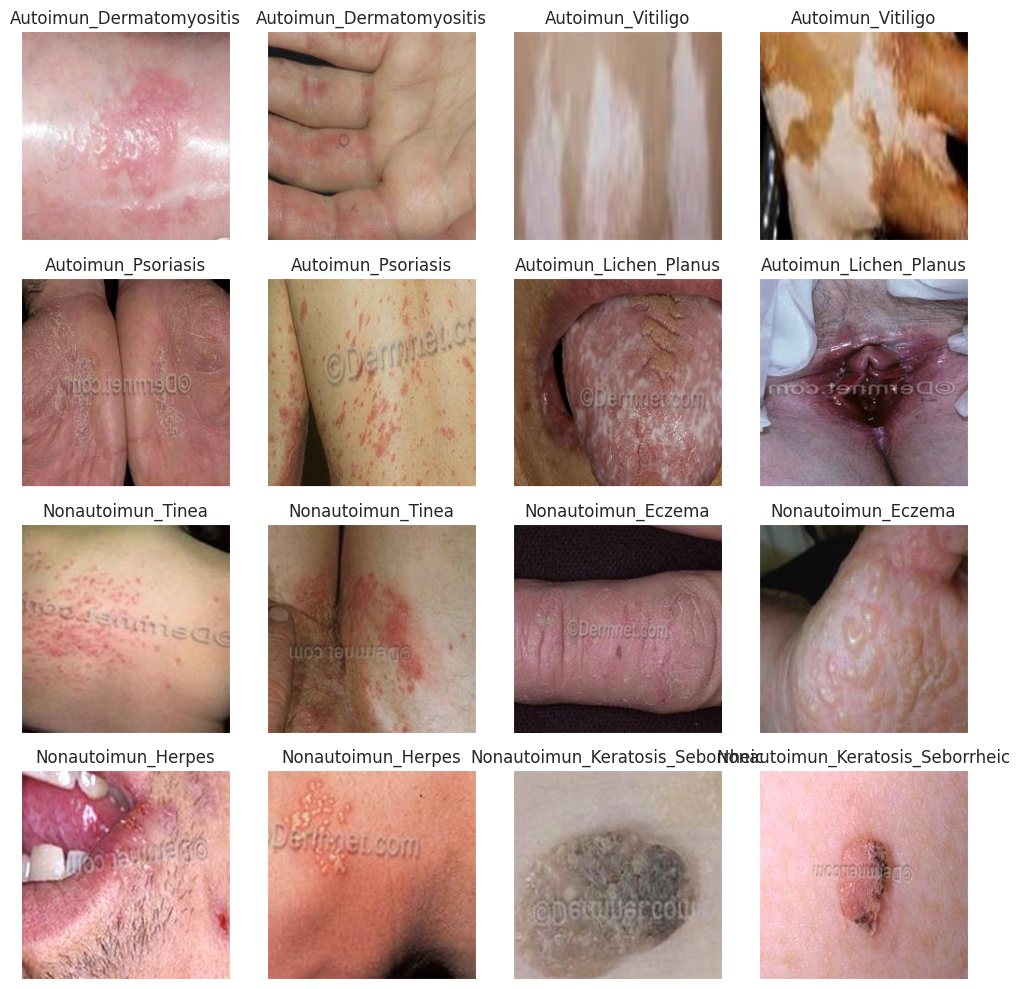

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

augmented_dir = '/content/drive/My Drive/DATASET/output/manipulation/augmented' # Replace with your base directory
diseases = ['Autoimun_Dermatomyositis', 'Autoimun_Vitiligo', 'Autoimun_Psoriasis', 'Autoimun_Lichen_Planus',
            'Nonautoimun_Tinea', 'Nonautoimun_Eczema', 'Nonautoimun_Herpes', 'Nonautoimun_Keratosis_Seborrheic']

num_images_per_disease = 2

# Collect image paths for each disease
image_paths = []
for disease in diseases:
    disease_dir = os.path.join(augmented_dir, disease)
    image_files = [f for f in os.listdir(disease_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]
    image_paths.extend([os.path.join(disease_dir, f) for f in random.sample(image_files, num_images_per_disease)])

# Display the images
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    img = mpimg.imread(image_paths[i])
    ax.imshow(img)
    ax.set_title(os.path.basename(os.path.dirname(image_paths[i])))  # Extract disease name from path
plt.tight_layout()
plt.show()

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

val_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 5120 validated image filenames belonging to 8 classes.
Found 1280 validated image filenames belonging to 8 classes.
Found 1600 validated image filenames belonging to 8 classes.


In [ ]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(224, 224), # Use layers.Resizing directly
  layers.Rescaling(1./255),  # Use layers.Rescaling directly
])

In [ ]:
# Load the pretained model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Create checkpoint callback
checkpoint_path = "autoimun_nonautoimun_classification_model_checkpoint.weights.h5"  # Added .weights.h5 extension
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Resizing, Rescaling
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard # Import TensorBoard

inputs = base_model.input
x = resize_and_rescale(inputs)  # Pass the input to the base model

X = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(base_model.output)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(8, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


model.compile(
    optimizer=tf.keras.optimizers.Adamax(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 4,098,632 (15.64 MB)

 Trainable params: 1,840,648 (7.02 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
def create_tensorboard_callback(dir_name, experiment_name):
    """
    Creates a TensorBoard callback for logging training progress.

    Args:
        dir_name: The directory where logs will be stored.
        experiment_name: The name of the experiment.

    Returns:
        A TensorBoard callback object.
    """
    log_dir = os.path.join(dir_name, experiment_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LambdaCallback
import datetime

# Custom function for early stopping based on accuracy
def early_stop_by_accuracy(epoch, logs):
    if logs.get('accuracy') is not None and logs['accuracy'] >= 0.96:
        print("\nReached 96% accuracy! Stopping training...")
        self.model.stop_training = True  # Assuming 'self' refers to the callback


# Create the LambdaCallback for early stopping by accuracy
accuracy_stopping = LambdaCallback(on_epoch_end=early_stop_by_accuracy)

# Pelatihan model
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,  # Early stopping based on val_loss
        accuracy_stopping, # Early stopping based on accuracy
        create_tensorboard_callback("training_logs", "autoimun_classification"),
        checkpoint_callback])

Saving TensorBoard log files to: training_logs/autoimun_classification/20241208-160309
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 3352s 20s/step - accuracy: 0.3224 - loss: 2.6802 - val_accuracy: 0.6586 - val_loss: 0.9494
Epoch 2/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/100


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 89s 347ms/step - accuracy: 0.5852 - loss: 1.1778 - val_accuracy: 0.7078 - val_loss: 0.7965
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 58s 350ms/step - accuracy: 0.6816 - loss: 0.9053 - val_accuracy: 0.7445 - val_loss: 0.6867
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 57s 349ms/step - accuracy: 0.7129 - loss: 0.7584 - val_accuracy: 0.7391 - val_loss: 0.6635
Epoch 8/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 78s 342ms/step - accuracy: 0.7455 - loss: 0.6784 - val_accuracy: 0.7859 - val_loss: 0.5763
Epoch 10/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 56s 340ms/step - accuracy: 0.7783 - loss: 0.5851 - val_ac

NameError: name 'self' is not defined

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.35585
Test Accuracy: 86.75%


In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the number of epochs for training and validation data
epochs_training = range(len(accuracy))
epochs_validation = range(len(val_accuracy))

# Plot training and validation accuracy
plt.plot(epochs_training, accuracy, 'b', label='Training accuracy')
plt.plot(epochs_validation, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()  # Create a new figure for the loss plot

# Plot training and validation loss
plt.plot(epochs_training, loss, 'b', label='Training loss')
plt.plot(epochs_validation, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: name 'history' is not defined

In [31]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 10 predictions: {pred[:10]}')

50/50 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step
The first 10 predictions: ['Autoimun_Psoriasis', 'Autoimun_Psoriasis', 'Autoimun_Vitiligo', 'Autoimun_Lichen_Planus', 'Nonautoimun_Herpes', 'Autoimun_Psoriasis', 'Autoimun_Vitiligo', 'Autoimun_Vitiligo', 'Nonautoimun_Tinea', 'Autoimun_Psoriasis']


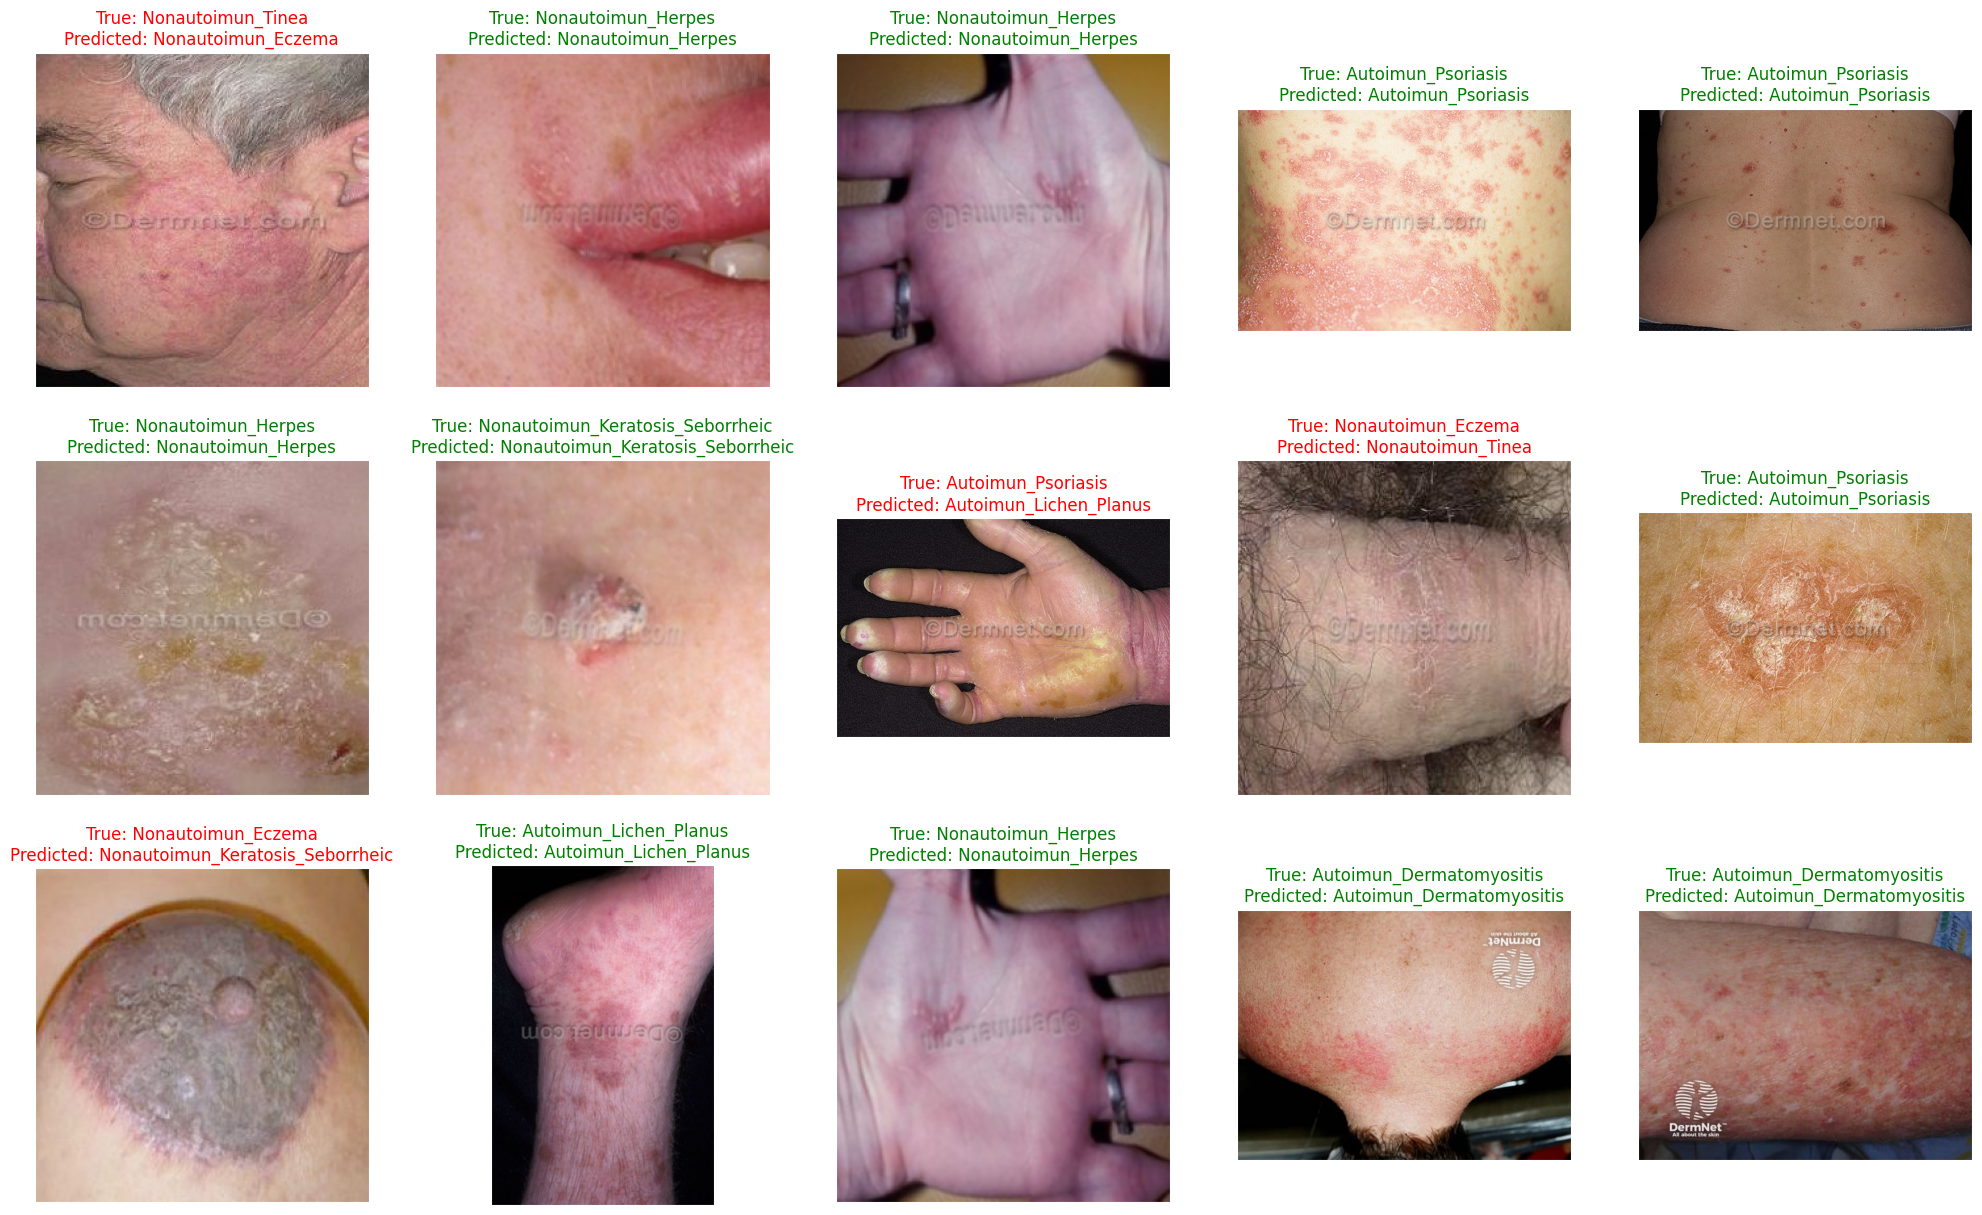

<Figure size 640x480 with 0 Axes>

In [33]:
 # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [34]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                                  precision    recall  f1-score   support

        Autoimun_Dermatomyositis       0.97      0.98      0.97       203
          Autoimun_Lichen_Planus       0.92      0.90      0.91       183
              Autoimun_Psoriasis       0.86      0.92      0.89       196
               Autoimun_Vitiligo       1.00      1.00      1.00       222
              Nonautoimun_Eczema       0.71      0.73      0.72       197
              Nonautoimun_Herpes       0.71      0.92      0.80       207
Nonautoimun_Keratosis_Seborrheic       0.96      0.91      0.94       192
               Nonautoimun_Tinea       0.87      0.56      0.68       200

                        accuracy                           0.87      1600
                       macro avg       0.87      0.87      0.86      1600
                    weighted avg       0.87      0.87      0.87      1600



In [35]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score    support
Autoimun_Dermatomyositis           0.966019  0.980296  0.973105   203.0000
Autoimun_Lichen_Planus             0.916667  0.901639  0.909091   183.0000
Autoimun_Psoriasis                 0.861905  0.923469  0.891626   196.0000
Autoimun_Vitiligo                  1.000000  1.000000  1.000000   222.0000
Nonautoimun_Eczema                 0.711443  0.725888  0.718593   197.0000
Nonautoimun_Herpes                 0.706320  0.917874  0.798319   207.0000
Nonautoimun_Keratosis_Seborrheic   0.961538  0.911458  0.935829   192.0000
Nonautoimun_Tinea                  0.869231  0.565000  0.684848   200.0000
accuracy                           0.867500  0.867500  0.867500     0.8675
macro avg                          0.874140  0.865703  0.863926  1600.0000
weighted avg                       0.874756  0.867500  0.865079  1600.0000

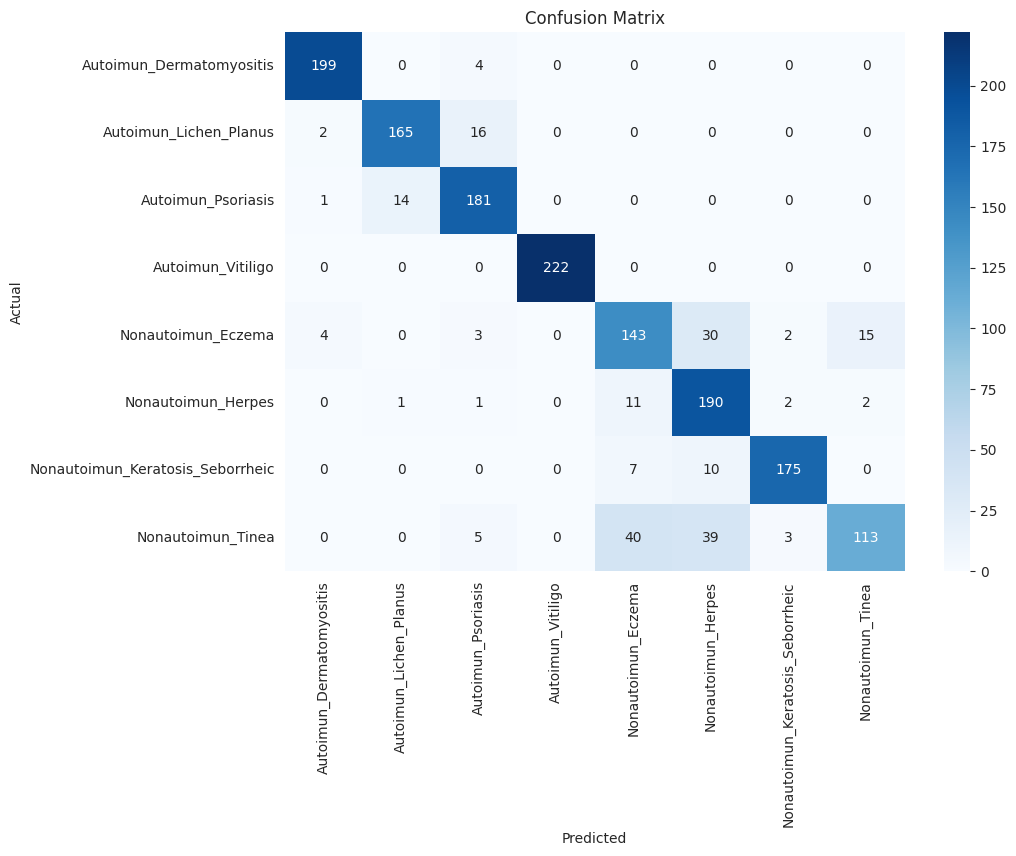

In [36]:
# Import the necessary function from scikit-learn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


def make_confusion_matrix(y_true, y_pred, labels):
    """
    Generates and displays a confusion matrix.

    Args:
        y_true: The true labels.
        y_pred: The predicted labels.
        labels: A list of label names.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


# Now you can use make_confusion_matrix in your code
# Use the complete y_test list instead of slicing it to match the length of pred
make_confusion_matrix(y_test, pred, list(labels.values()))

In [ ]:
last_layer_name = model.layers[-1].name
print(last_layer_name)

dense_11


In [41]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

# Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [42]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))

    return cam_path

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "block_14_add"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

<ipython-input-42-00c4da2af479>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


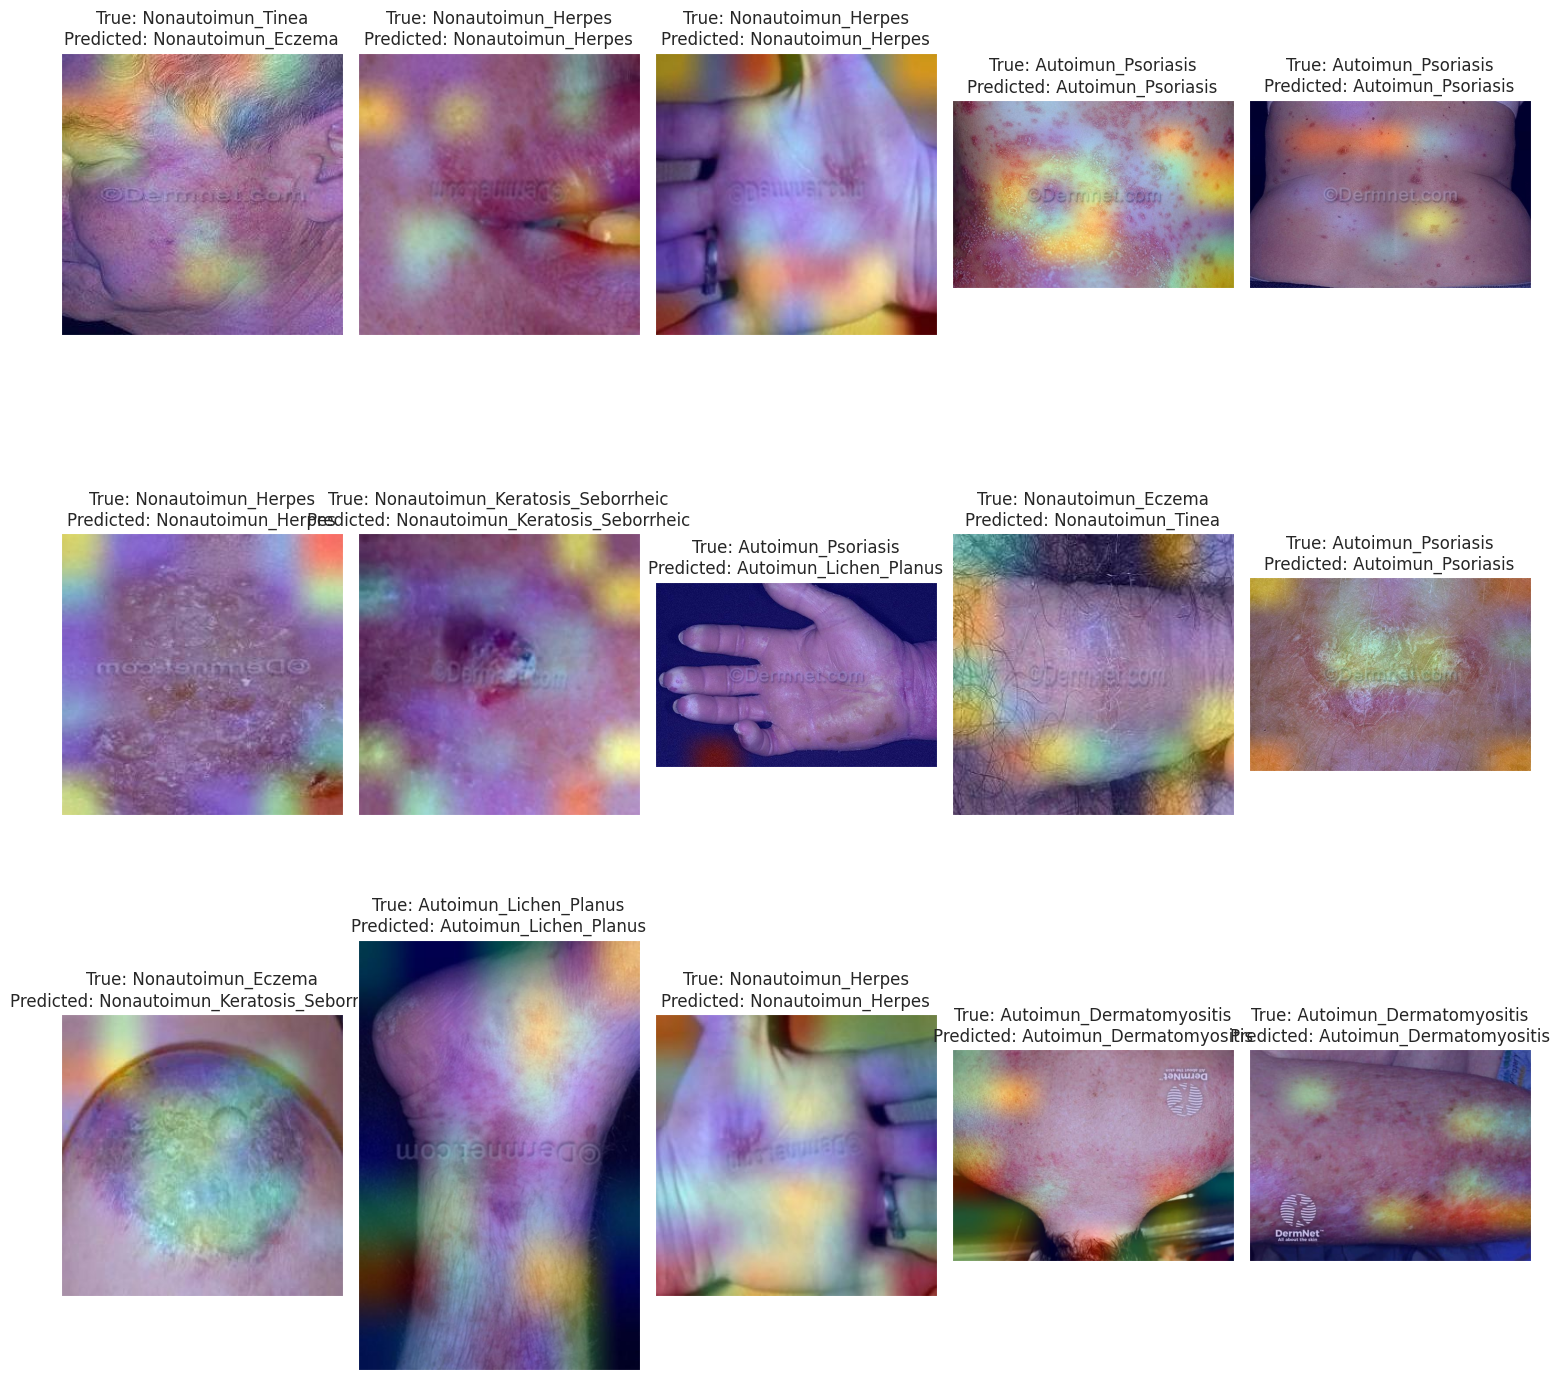

In [45]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()